- Yanxin Zhang
- uni: yz3698
- e-mail:yz3698@columbia.edu


#### This report is composed of 8 parts:
- 1. Introduction
- 2. Data preparation
- 3. Feature Engineering (for content-based model)
- 4. First layer model(collaborative filtering) hyperparameter tuning and evaluation
- 5. Second layer model (Content-based) hyperparameter tuning and evaluation
- 6. The hybrid model hyperparameter tuning and evaluation (including comparation with benchmark and simple collaborative filtering model)
- 7. The complete model for prediction and model exploration
- 8. summary and reflection

# 1. Introduction
This report is aimed at building a movie recommendation system that would meet the following three goals：

- 1. Recommend users with movies that best align with their taste 
- 2. Recommend users a set of movies that are diversified, that is, we should not always recommend user with movies that are of the same genres. The number of different genres we recommend to a user should be too small.
- 3. Take ecosystem heath into consideration. We should not always recommend users with popular movies and mainstream genres. The movies that are less popular and genres that are less common should also take a fraction.

The system is composed of three parts:
- 1. Model-based collaborative filtering to generate initial candidates.
- 2. Content-based model together with the predicted rating of the collaborative filtering model to rerank the candidates
     - The content-based model utilized two types of features:
          - Movie features including movie genres and tags
          - User profile features based on user's past behavior.
- 3. Business rules
     - including diversity and ecosystem heath adjustment
 

To better align with the business nature, we keep the most recent 5 records of each user as the validation and test set. 

# 2. Data Preparation

In [1]:
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import pickle
import warnings
import gc
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
np.random.seed(43)

In [2]:
path='ml-latest/'
rating=pd.read_csv(path+"ratings.csv")

movie_tag=pd.read_csv(path+"genome-scores.csv")
movie_tag=movie_tag.pivot(index="movieId", columns="tagId",values="relevance")

genres=pd.read_csv(path+"movies.csv")
genres_list=['Action','Adventure','Animation',
            'Children','Comedy','Crime',
            'Documentary','Drama','Fantasy','Film-Noir',
            'Horror','Musical','Mystery','Romance',
            'Sci-Fi','Thriller','War','Western']
for g in genres_list:
    genres[g]=genres["genres"].str.contains(g)*1
    


In [3]:
movie_tag.shape

(13176, 1128)

#### Data movie tags has 1128 dimensions of features, which is too much for the later feature engineering and content-based model training on the local machine. Therefore, a linear PCA was conducted to reduce dimensions. 
(have also tried autoencoder and kernal PCA. However autoencoder tend to overfit on this movie dataset. And kernal PCA take too long to run on the local machine. Code is appended in the appendix.)

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA,KernelPCA

x = movie_tag.copy()
x = StandardScaler().fit_transform(x)

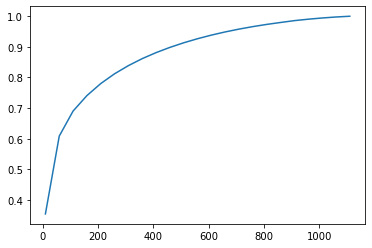

In [112]:
dic={}
for i in np.arange(10,1146,50):
    pca = PCA(n_components=i)
    #kpca = KernelPCA(n_components=i,kernel="rbf")
    principalComponents = pca.fit_transform(x)
    dic[i]=sum(pca.explained_variance_ratio_)

pca_df=pd.DataFrame(dic,index=[0]).T.reset_index()
plt.plot(pca_df['index'],pca_df[0])
plt.show()

- Choose 200 components, which keeps 77% of the variance of the original data. 

In [5]:
pca = PCA(n_components=200)
principalComponents = pca.fit_transform(x)
movie_tags_pca=pd.DataFrame(principalComponents,index=movie_tag.index).reset_index()
sum(pca.explained_variance_ratio_)

0.7728073846159879

In [6]:
def sample_dataset(data,item_frac,user_frac,movie_bar=0,user_bar=0):
    import random
    u_cnt=data.groupby("movieId").count()["userId"].sample(frac=item_frac)
    qualified_movies=u_cnt[u_cnt>=movie_bar].index.values
    data=data[data.movieId.isin(qualified_movies)]

    m_cnt=data.groupby("userId").count()["movieId"].sample(frac=user_frac)
    qualified_users=m_cnt[m_cnt>=user_bar].index.values
    
    sample=data[data.userId.isin(qualified_users)]
    print("unique users: ",len(qualified_users),"unique movies: ",sample['movieId'].unique().shape[0])
    return sample

# 3. Feature Engineering 
(for content-based model)
### 3.1 Movie features
Two types of features
- Genres
- Tags

In [7]:
movie_features=genres
def extract_year(x):
    x=x.rsplit('(',1)[-1].replace(')','').replace('2006–2007','2006')
    try:
        x=float(x)
    except:
        x=np.nan
    return x

movie_features['year']=movie_features['title'].apply(lambda x:extract_year(x))
movie_features=movie_features.merge(movie_tags_pca,on='movieId',how='left')

In [8]:
np.random.seed(43)
df_sub = sample_dataset(rating,user_frac=0.35,item_frac=0.04,user_bar=6) 

## merge with movie features
df_sub=df_sub.merge(movie_features,on='movieId',how='left')
df_sub.columns=[str(i) for i in df_sub.columns ]

features=genres_list.copy()
features.extend(list(np.arange(200)))
features=[str(i) for i in features]

unique users:  23583 unique movies:  1670


### 3.2Construct User Profile
In this part we construct user profiles based on their past rating behavior.
- First, all their past rating would be deducted with 3.5, the assumption is that movies with ratings<3.5 is the movie that the user doesn't like, by -3.5 it will have a negative sign. Movies with ratings>3.5 is the movie that the user like, after -3.5 it will still have a possitive sign.
- Second, mutiply the rescaled rating with the the features of the movie (for example, genres). Therefore, if a user have a negative score on that movie, the user would also have a negative score on the genre that the movie belong to.
- Therefore, a user that have mutiple movie rating records will also have mutiple 'rating' records on the genres and tags those movies belong to. The users's current profile would be a weighted average of their past 'ratings' on the tags and genres. The weights of past 'rating' will decay exponentially. The more recent records will get higher weight than old records.
- Finally, some genres have more movies compared with others, therefore these genres also have more ratings compared with other genres. We deal with this influence by introducing TFIDF technique when construct user profile. The assumption here is that the files movies.csv contains all the movies available that the users can be shown. So we could calculate document frequency based on this file.


##### As a summray, the user profile is composed of 3 parts:
- Rating on the movie feature
- Time Weight
- TFIDF Weight (for genres)

In [10]:
df_sub['rating_rescale']=df_sub['rating'].apply(lambda x:x-3.5)
# all the past rating would be deducted with 3.5

user_profile_features=[str(i)+'_user' for i in features]

df_sub[user_profile_features]=df_sub[features].mul(df_sub['rating_rescale'],axis="index")
# mutiply the rescaled rating with the the features of the movie

user_genres_lst=[str(i)+'_user' for i in genres_list]

emw_lst=user_profile_features.copy()
emw_lst.append('rate_time') # list for construct user profile

TFIDF_w_factors=1/movie_features[genres_list].sum() # calculate doucument frequency for each genre

In [38]:
df_sub['rate_time']=pd.to_datetime(df_sub['timestamp'],unit='s')


def construct_user_profile(df,halflife_time):
    df_u=df.groupby('userId')[emw_lst]\
           .apply(lambda x: x.ewm(halflife=halflife_time,times=x['rate_time']).mean().shift(1).fillna(0))
    #The users's current profile would be a weighted average of their past 'ratings' on the tags and genres. 
    #The weights of past 'rating' will decay exponentially. 
    # here we use halflife to control the speed of decay.
    # half life: the time unit (str or timedelta) over which an observation decays to half its value.
    
    for g in genres_list:
        df_u[g+'_user']=df_u[g+'_user']*TFIDF_w_factors[g] # weight by document frequency
    df[user_profile_features]=df_u.reset_index()[user_profile_features]
    return df

# Half life is a parameter that we could tune
# As the calculation will take a long time, we only test two halflife values, 30 days and 90 days here.
halflife_lst=[30,90]
halflife_lst=[str(i)+' days' for i in halflife_lst]

start=time.time()

df_sub_30=construct_user_profile(df_sub,halflife_lst[0])
df_sub_30.to_csv('df_sub_30.csv')

df_sub_90=construct_user_profile(df_sub,halflife_lst[1])
df_sub_90.to_csv('df_sub_90.csv')

end=time.time()
print((end-start)/60)

56.85353033145269


In [12]:
#df_sub_90=pd.read_csv('df_sub_90.csv')

In [13]:
all_features=user_profile_features.copy()
all_features.extend([str(i) for i in features])
all_features_std=[str(i)+'_std' for i in all_features]

In [15]:
# standardize the features
df_sub_lst=[df_sub_30,df_sub_90]
i=0
for df in df_sub_lst:
    scaler = StandardScaler().fit(df[all_features].fillna(0))
    pickle.dump(scaler, open(halflife_lst[i]+'_scaler', 'wb'))
    x=scaler.transform(df[all_features].fillna(0))
    df[all_features_std]=x
    i=i+1
    

In [16]:
#use the most recent 5 records of each user as the validation set and test set
def build_crossvalidated_dataset(data,threshold=5):
    from sklearn.model_selection import train_test_split

    data['sort']=data.groupby("userId")['timestamp'].rank(method='dense',ascending=0)
    
    train=data[data['sort'].apply(lambda x:x>=threshold)]
    valid_test=data[data['sort'].apply(lambda x:x<=threshold)]
    valid,test=train_test_split(valid_test,test_size=0.50)
    
    return train,valid,test

# 4. Layer 1: Model-based collaborative filtering: MF
(reuse of hw2)
#### This layer will generate candidates for next model.
### 4.1 

In [17]:
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("final").getOrCreate()

In [18]:
np.random.seed(43)
train,valid,test= build_crossvalidated_dataset(df_sub,threshold=5)
rating_col=['userId', 'movieId', 'rating']
train_sc=spark.createDataFrame(train[rating_col].values.tolist(), rating_col)
valid_sc=spark.createDataFrame(valid[rating_col].values.tolist(), rating_col)
test_sc=spark.createDataFrame(test[rating_col].values.tolist(),rating_col)

In [19]:
def label(x):
    # Here we assumed that the movies that the user rated >=4 is relevent and otherwise irrelevent
    if x<4:
        return 0
    if x>=4:
        return 1

def evaluation_acc(data,prediction,label,predicted_label):
    from sklearn.metrics import mean_squared_error, ndcg_score,roc_curve,auc
    mse=mean_squared_error(data,prediction)#primary metric
    ndcg=ndcg_score(label.values.reshape(1,-1),prediction.values.reshape(1,-1))#secondary metric
    return mse,ndcg

def train_and_eval_mf(trainset,testset,rank,maxIter,regParam):
    from pyspark.ml.recommendation import ALS
    als = ALS(userCol="userId", itemCol="movieId", ratingCol="rating",nonnegative=True,
              rank=rank, 
              maxIter=maxIter, regParam=regParam, 
              coldStartStrategy="drop",seed=43)
    mf_model = als.fit(trainset)
    #print(testset.toPandas().shape)
    df_pred = mf_model.transform(testset).toPandas().rename(columns={"rating":"actual_rating"})
    #print(df_pred.shape)
    df_pred=df_pred.rename(columns={"rating":"actual_rating"})
    df_pred["label"]=df_pred["actual_rating"].apply(lambda x:label(x))
    df_pred["label_predicted"]=df_pred["prediction"].apply(lambda x:label(x))
    mse,ndcg=evaluation_acc(df_pred["actual_rating"],df_pred["prediction"],df_pred["label"],df_pred["label_predicted"])
    return mse,ndcg,df_pred,mf_model

In [20]:
## Tune hyperparameters:
## Rank: the number of latent factors in the model
## regParam:the regularization parameter in ALS
rpt_mf=pd.DataFrame()
rank_list=[5,10,15,20,30,50]
regParam_list=[0.01,0.1,0.2,0.3,0.4,0.5]
for r in rank_list:
    for l in regParam_list:
        mse,ndcg,auc,tpr,df_pred,mf_model=train_and_eval_mf(train_sc,valid_sc,rank=r,maxIter=5,regParam=l)
        dic={"rank":r,"regParam":l,"mse":mse,"ndcg":ndcg}
        line=pd.DataFrame(dic,index=[0])
        rpt_mf=rpt_mf.append(line)
rpt_mf.sort_values(by="mse").head()

,rank,regParam,mse,ndcg
0,10,0.2,0.804117,0.973765
0,20,0.2,0.814441,0.974335
0,15,0.2,0.814783,0.974321
0,5,0.2,0.825055,0.972525
0,50,0.2,0.831231,0.974535


- Therefore, the optimal params set is rank=10, regParam=0.2.The charts below show how the metrics change as a function of these hyperparameters

In [20]:
mse,ndcg,df_pred_mf,mf_model=train_and_eval_mf(train_sc,valid_sc,rank=10,maxIter=5,regParam=0.2)

In [97]:
mf_model.save("mf_model")

## 4.2 Evaluate model performance on different user segments and different movies
- Compare how the matrix factorization model performs on users that have less rating history and users that have more rating history
- Compare how the matrix factorization model performs on movies that have less rating records and movies that have more rating records.

In [38]:
cnt=train.groupby('userId').count()['movieId']
cnt.describe()
# Show the distribution of user rating records counts in the training set

count    23501.000000
mean        12.791966
std         15.997481
min          1.000000
25%          4.000000
50%          7.000000
75%         16.000000
max        337.000000
Name: movieId, dtype: float64

In [40]:
less_than_5=cnt[cnt<5].index.values
more_than_5=cnt[cnt>=5].index.values
df_pred_less_than_5_mf=df_pred_mf[df_pred_mf['userId'].isin(less_than_5)]
df_pred_more_than_5_mf=df_pred_mf[df_pred_mf['userId'].isin(more_than_5)]
table_mf=pd.DataFrame()
mse,ndcg=evaluation_acc(df_pred_less_than_5_mf["actual_rating"],df_pred_less_than_5_mf["prediction"],df_pred_less_than_5_mf["label"],df_pred_less_than_5_mf["label_predicted"])
table_mf=table_mf.append(pd.DataFrame(('less than 5',mse,ndcg),index=['user_group','mse','ndcg']).T)
mse,ndcg=evaluation_acc(df_pred_more_than_5_mf["actual_rating"],df_pred_more_than_5_mf["prediction"],df_pred_more_than_5_mf["label"],df_pred_more_than_5_mf["label_predicted"])
table_mf=table_mf.append(pd.DataFrame(('more than 5',mse,ndcg),index=['user_group','mse','ndcg']).T)

In [41]:
table_mf

,user_group,mse,ndcg
0,less than 5,0.937871,0.971297
0,more than 5,0.731506,0.970494


- The matrix factorization model perform much better in terms of mean square error on users that >= 5 rating records in the training set.

In [21]:
cnt=train.groupby('movieId').count()['userId']
cnt.describe()
# Show the distribution of movie rating records counts in the training set

count     1558.000000
mean       192.955071
std        802.411352
min          1.000000
25%          1.000000
50%          4.500000
75%         35.000000
max      11271.000000
Name: userId, dtype: float64

In [30]:
m_less_than_30=cnt[cnt<30].index.values
m_more_than_30=cnt[cnt>=30].index.values
m_df_pred_less_than_30_mf=df_pred_mf[df_pred_mf['movieId'].isin(m_less_than_5)]
m_df_pred_more_than_30_mf=df_pred_mf[df_pred_mf['movieId'].isin(m_more_than_5)]

m_table_mf=pd.DataFrame()
mse,ndcg=evaluation_acc(m_df_pred_less_than_30_mf["actual_rating"],m_df_pred_less_than_30_mf["prediction"],m_df_pred_less_than_30_mf["label"],m_df_pred_less_than_5_mf["label_predicted"])
m_table_mf=m_table_mf.append(pd.DataFrame(('less than 30',mse,ndcg),index=['user_group','mse','ndcg']).T)
mse,ndcg=evaluation_acc(m_df_pred_more_than_30_mf["actual_rating"],m_df_pred_more_than_30_mf["prediction"],m_df_pred_more_than_30_mf["label"],m_df_pred_more_than_5_mf["label_predicted"])
m_table_mf=m_table_mf.append(pd.DataFrame(('more than 30',mse,ndcg),index=['user_group','mse','ndcg']).T)


In [31]:
m_table_mf

,user_group,mse,ndcg
0,less than 30,1.06068,0.931572
0,more than 30,0.793915,0.972496


- The matrix factorization model perform much better in terms of both mean square error and ndcg on movies that >= 30 rating records in the training set.

# 5. Layer 2: content-based model
This layer would help rerank the candidates generated by the first layer.
Input of the model:
- movie features
- user profile features

xgboost regressor is used here.
(have also tried deep learning model but running dl model with this size of data and features is beyond the capacity of my local machine. The code is also appended in the appendix.)

### 5.1 Tune hyperparameters:
- halflife
- max_depth
- min_child_weight

In [32]:
def train_and_eval_xgb(train,valid,max_depth,min_child_weight,halflife):
    from xgboost import XGBRegressor
    model = XGBRegressor(max_depth=max_depth,
                        learning_rate=0.01,
                        n_estimators=500,
                        silent=True,
                        objective='reg:squarederror',
                        gamma=0,
                        min_child_weight=min_child_weight,
                        subsample=0.85,
                        colsample_bytree=0.7,
                        colsample_bylevel=1,
                        reg_alpha=0,
                        reg_lambda=1,
                        seed=43,
                        missing=None)

    model.fit(train[all_features_std],
              train['rating'],
               eval_set = [(valid[all_features_std],valid['rating'])],
               early_stopping_rounds = 10,
               verbose = 10)
    
    import pickle
    filename = 'xgb'+str(max_depth)+str(min_child_weight)+str(halflife)+'.model'
    pickle.dump(model, open(filename, 'wb'))
    valid['prediction'] = model.predict(valid[all_features_std])
    valid["label"]=valid["rating"].apply(lambda x:label(x))
    valid["label_predicted"]=valid["prediction"].apply(lambda x:label(x))
    mse,ndcg,auc=evaluation_acc(valid["rating"],valid["prediction"],valid["label"],valid["label_predicted"])
    
    return mse,ndcg,auc,filename,model
    
    
    

In [33]:
df_sub_lst=[df_sub_30,df_sub_90]
halflife_lst=['30 days','90 days']
max_depth=[8,7,6]
min_child_weight=[1,2]

rpt_xgb=pd.DataFrame()
for i in range(len(halflife_lst)):
    train,valid,test= build_crossvalidated_dataset(df_sub_lst[i],threshold=5)
    for depth in max_depth:
        for w in min_child_weight:
            mse,ndcg,auc,filename,model=train_and_eval_xgb(train,valid,max_depth=depth,min_child_weight=w,halflife=halflife_lst[i])
            dic={'model_name':filename,
                "halflife":halflife_lst[i],"depth":depth,
                 "min_child_weight":w,
                 "mse":mse,'auc':auc,"ndcg":ndcg}
            line=pd.DataFrame(dic,index=[0])
            #display(line)
            rpt_xgb=rpt_xgb.append(line)       

In [46]:
rpt_xgb.sort_values(by="mse")   

,model_name,halflife,depth,min_child_weight,mse,auc,ndcg
0,xgb8290 days.model,90 days,8,2,0.804799,0.560613,0.965510
0,xgb8190 days.model,90 days,8,1,0.804931,0.560317,0.965460
0,xgb8230 days.model,30 days,8,2,0.806290,0.562203,0.966229
0,xgb8130 days.model,30 days,8,1,0.806349,0.562500,0.966168
0,xgb7190 days.model,90 days,7,1,0.812923,0.556500,0.964854
0,xgb7290 days.model,90 days,7,2,0.813104,0.556187,0.964827
0,xgb7130 days.model,30 days,7,1,0.814728,0.557216,0.965563
0,xgb7230 days.model,30 days,7,2,0.814774,0.557117,0.965552
0,xgb6290 days.model,90 days,6,2,0.819623,0.552449,0.964239
0,xgb6190 days.model,90 days,6,1,0.819639,0.552615,0.964238


#### Therefore, the optimal hyperparameter combination for the content-based model is halflife=90 days, max_depth=8, min_child_weight=2. 
(please ignore the auc above, it is not accurate but rerun the process would take another day..)

In [34]:
del df_sub_30
gc.collect()

In [35]:
# load trained model

#xgb_model=pickle.load(open('xgb8290 days.model', 'rb'))
#np.random.seed(43)
#train,valid,test = build_crossvalidated_dataset(df_sub_90,threshold=5)

## 5.2 Evaluate model performance on different user segments and different movies
- Compare how the content-based model performs on users that have less rating history and users that have more rating history
- Compare how the content-based model performs on movies that have less rating records and movies that have more rating records.

In [36]:
df_pred_xgb=valid.copy().rename(columns={"rating":"actual_rating"})
df_pred_xgb['prediction']=xgb_model.predict(df_pred_xgb[all_features_std])
df_pred_xgb["label"]=df_pred_xgb["actual_rating"].apply(lambda x:label(x))
df_pred_xgb["label_predicted"]=df_pred_xgb["prediction"].apply(lambda x:label(x))

In [42]:
df_pred_less_than_5_xgb=df_pred_xgb[df_pred_xgb['userId'].isin(less_than_5)]
df_pred_more_than_5_xgb=df_pred_xgb[df_pred_xgb['userId'].isin(more_than_5)]

In [265]:
table_xgb=pd.DataFrame()
mse,ndcg=evaluation_acc(df_pred_less_than_5_xgb["actual_rating"],df_pred_less_than_5_xgb["prediction"],df_pred_less_than_5_xgb["label"],df_pred_less_than_5_xgb["label_predicted"])
table_xgb=table_xgb.append(pd.DataFrame(('less than 5',mse,ndcg),index=['user_group','mse','ndcg']).T)
mse,ndcg=evaluation_acc(df_pred_more_than_5_xgb["actual_rating"],df_pred_more_than_5_xgb["prediction"],df_pred_more_than_5_xgb["label"],df_pred_more_than_5_xgb["label_predicted"])
table_xgb=table_xgb.append(pd.DataFrame(('more than 5',mse,ndcg),index=['user_group','mse','ndcg']).T)
table_xgb

,user_group,mse,ndcg
0,less than 5,0.872252,0.964964
0,more than 5,0.761919,0.963606


In [266]:
table_mf

,user_group,mse,ndcg
0,less than 5,0.937871,0.971297
0,more than 5,0.731506,0.970494


Compare the collaborative filtering model with the content-based model:
- the content-based model out-perform the collaborative filtering model in terms of mean square error on the user segment that has less than 5 rating history in the training set, but perform worse on the user segment that has more than 5 rating history.

In [43]:
m_df_pred_less_than_30_xgb=df_pred_xgb[df_pred_xgb['userId'].isin(m_less_than_30)]
m_df_pred_more_than_30_xgb=df_pred_xgb[df_pred_xgb['userId'].isin(m_more_than_30)]

In [45]:
m_table_xgb=pd.DataFrame()
mse,ndcg=evaluation_acc(m_df_pred_less_than_30_xgb["actual_rating"],m_df_pred_less_than_30_xgb["prediction"],m_df_pred_less_than_30_xgb["label"],m_df_pred_less_than_30_xgb["label_predicted"])
m_table_xgb=m_table_xgb.append(pd.DataFrame(('less than 30',mse,ndcg),index=['user_group','mse','ndcg']).T)
mse,ndcg=evaluation_acc(m_df_pred_more_than_30_xgb["actual_rating"],m_df_pred_more_than_30_xgb["prediction"],m_df_pred_more_than_30_xgb["label"],m_df_pred_more_than_30_xgb["label_predicted"])
m_table_xgb=m_table_xgb.append(pd.DataFrame(('more than 30',mse,ndcg),index=['user_group','mse','ndcg']).T)
m_table_xgb

,user_group,mse,ndcg
0,less than 30,0.874093,0.915996
0,more than 30,0.793566,0.928474


In [46]:
m_table_mf

,user_group,mse,ndcg
0,less than 30,1.06068,0.931572
0,more than 30,0.793915,0.972496


Compare the collaborative filtering model with the content-based model:
- the content-based model out-perform the collaborative filtering model in terms of mean square error on the movies that has less than 30 rating history in the training set. Perform equally on the movies that has more than 30 rating history.




# 6. The hybrid model hyperparameter tuning and evaluation
### 6.1 Hyperparameter tuning
- Based on the results above, we consider to combine the prediction results of the two models. Because we are more concerned about the model performance on users, we will divide the users to 2 segments and try to find the best mix of the two models for each user segment.

In [318]:
from sklearn.metrics import mean_squared_error
    
### ensamble:
xgb_weight=np.arange(11)/10
ensamble_rpt=pd.DataFrame()
for w in xgb_weight:
    df_pred=df_pred_xgb.drop(columns=['actual_rating']).rename(columns={"prediction":"prediction_xgb"})\
                       .merge(df_pred_mf.rename(columns={"prediction":"prediction_mf"}),
                               on=['userId','movieId'],how='inner')
    df_pred['weighted_rating']=w*df_pred['prediction_xgb']+(1-w)*df_pred['prediction_mf']
    mse_all=mean_squared_error(df_pred['actual_rating'],df_pred['weighted_rating'])
    mse_less=mean_squared_error(df_pred[df_pred['userId'].isin(less_than_5)]['actual_rating'],df_pred[df_pred['userId'].isin(less_than_5)]['weighted_rating'])
    mse_more=mean_squared_error(df_pred[df_pred['userId'].isin(more_than_5)]['actual_rating'],df_pred[df_pred['userId'].isin(more_than_5)]['weighted_rating'])
    line={'xgb_weight':w,'all':mse_all,'less_than_5':mse_less,'more_than_5':mse_more}
    line=pd.DataFrame(line,index=[0])
    ensamble_rpt=ensamble_rpt.append(line)
    
    
    

In [319]:
ensamble_rpt

,xgb_weight,all,less_than_5,more_than_5
0,0.0,0.798131,0.937871,0.731506
0,0.1,0.776113,0.897068,0.718444
0,0.2,0.758970,0.863872,0.708955
0,0.3,0.746703,0.838284,0.703038
0,0.4,0.739311,0.820304,0.700695
0,0.5,0.736794,0.809931,0.701924
0,0.6,0.739153,0.807166,0.706725
0,0.7,0.746387,0.812008,0.715100
0,0.8,0.758496,0.824458,0.727047
0,0.9,0.775481,0.844516,0.742567


Text(0.5, 1.0, 'Differnt weight of content-based model in the hybrid model and MSE')

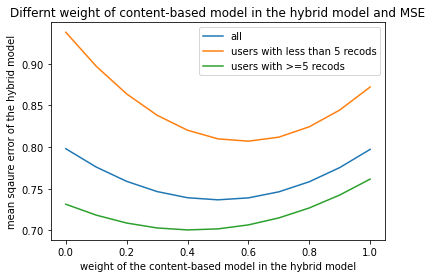

In [362]:
plt.plot(ensamble_rpt['xgb_weight'],ensamble_rpt['all'],label='all')
plt.plot(ensamble_rpt['xgb_weight'],ensamble_rpt['less_than_5'],label='users with less than 5 recods')
plt.plot(ensamble_rpt['xgb_weight'],ensamble_rpt['more_than_5'],label='users with >=5 recods')
plt.legend()
plt.xlabel('weight of the content-based model in the hybrid model')
plt.ylabel('mean sqaure error of the hybrid model')
plt.title('Differnt weight of content-based model in the hybrid model and MSE')

If we use the weighted average of the predicted rating of the two models, the performance for both groups (<5 and >=5) would be improved. The table above also shows that:
- for users that have less than 5 records in the training set, it is optimal to choose 0.6 as the weight for content-based model (xgb) and 0.4 for the collaborative filtering model.
- for users that have more than 5 records in the training set, it is optimal to choose 0.4 as the weight for content-based model (xgb) and 0.6 for the collaborative filtering model.

In [227]:
mse_mf_rpt,ndcg_mf_rpt,df_pred_mf_rpt,_=train_and_eval_mf(train_sc,test_sc,rank=10,maxIter=5,regParam=0.2)

In [223]:
def hybrid_predict(data):
    rating_col=['userId', 'movieId', 'rating']
    data_sc=spark.createDataFrame(test[rating_col].values.tolist(),rating_col)
    mf_pred=mf_model.transform(data_sc).toPandas().rename(columns={"rating":"actual_rating",'prediction':'mf_prediction'})
    data['xgb_prediction']=xgb_model.predict(data[all_features_std])
    data=data.merge(mf_pred,on=['userId','movieId'],how='inner')
    seg1=data[data['userId'].isin(less_than_5)]
    seg1['prediction']=0.6*seg1['xgb_prediction']+0.4*seg1['mf_prediction']
    seg2=data[data['userId'].isin(more_than_5)]
    seg2['prediction']=0.4*seg2['xgb_prediction']+0.6*seg2['mf_prediction']
    hybrid=pd.concat([seg1,seg2],axis=0)
    return hybrid

In [225]:
hybrid_pred=hybrid_predict(test)
hybrid_pred["label"]=hybrid_pred["actual_rating"].apply(lambda x:label(x))
hybrid_pred["label_predicted"]=hybrid_pred["prediction"].apply(lambda x:label(x))
mse_hybrid,ndcg_hybrid=evaluation_acc(hybrid_pred["actual_rating"],hybrid_pred["prediction"],hybrid_pred["label"],hybrid_pred["label_predicted"])

In [226]:
## The accuracy performance of the hybrid model on the test set
mse_hybrid,ndcg_hybrid

(0.7440904555850237, 0.9724062764052196)

## 6.2 Evaluation:
####  Compare with benchmarks (baseline model and simple collabrative filtering model) in terms of:
- accuracy
- coverage: In all the users' top 10, how many movies would be covered.
- diversity: In each users' top 10, on average what proportion of genres would be covered.

#####  Baseline: Predict the rating with the average rating of the movies in the training set.

### Baseline recommendation top 10

In [124]:
#get the mean rating for each movie
lookuptable=train.groupby("movieId").mean()[["rating"]].rename(columns={"rating":"prediction"})
# get prediction for the test set based on the mean
df_pred_bench=test.merge(lookuptable,on=["movieId"],how="inner")
# evaluation:
df_pred_bench["label"]=df_pred_bench["rating"].apply(lambda x:label(x))
df_pred_bench["label_predicted"]=df_pred_bench["prediction"].apply(lambda x:label(x))
mse_bench,ndcg_bench=evaluation_acc(df_pred_bench["rating"],df_pred_bench["prediction"],df_pred_bench["label"],df_pred_bench["label_predicted"])

In [204]:
#the baseline model would recommend the movies with the highest average rating to all users.
recommend_base=lookuptable.sort_values(by='prediction',ascending=False).iloc[:10].reset_index()
recommend_base['userId']=0

### Simple collabrative filtering recommendation top 10

In [167]:
# simple collabrative filtering
recommend=mf_model.recommendForAllUsers(10).toPandas()
user_look_up_table=recommend.reset_index()[['index','userId']]
recommend_cl=recommend['recommendations'].map(lambda x:list(map(lambda i:str(i['movieId'])+'&'+str(i['rating']),x))).explode().reset_index()
recommend_cl[['movieId','prediction']]=recommend_cl['recommendations'].str.split('&',expand=True)
recommend_cl['prediction']=recommend_cl['prediction'].astype(float)
recommend_cl['movieId']=recommend_cl['movieId'].astype(int)
recommend_cl=recommend_cl.merge(user_look_up_table,how='left',on='index')

### Hybrid model recommendation top 10

In [150]:
recommend=mf_model.recommendForAllUsers(30).toPandas()
user_look_up_table=recommend.reset_index()[['index','userId']]
recommend_hybrid=recommend['recommendations'].map(lambda x:list(map(lambda i:str(i['movieId'])+'&'+str(i['rating']),x))).explode().reset_index()
recommend_hybrid[['movieId','prediction']]=recommend_hybrid['recommendations'].str.split('&',expand=True)
recommend_hybrid['mf_prediction']=recommend_hybrid['mf_prediction'].astype(float)
recommend_hybrid=recommend_hybrid.merge(user_look_up_table,how='left',on='index')

In [151]:
u=[i for i in all_features_std if 'user' in i]
u.append('userId')
m=[i for i in all_features_std if not 'user' in i]
m.append('movieId')

movie_features_lookup=train.drop_duplicates(subset='movieId')[m]
user_profiles_lookup=train.loc[train.groupby('userId').apply(lambda x: x['timestamp'].idxmax())][u]

recommend_hybrid['movieId']=recommend_hybrid['movieId'].astype(int)
recommend_hybrid=recommend_hybrid.merge(movie_features_lookup,on='movieId',how='left')
recommend_hybrid=recommend_hybrid.merge(user_profiles_lookup,on='userId',how='left')
recommend_hybrid=recommend_hybrid.rename(columns={'prediction':'mf_prediction'})

In [160]:
recommend_hybrid['xgb_prediction']=xgb_model.predict(recommend_hybrid[all_features_std])
seg1=recommend_hybrid[recommend_hybrid['userId'].isin(less_than_5)]
seg1['prediction']=0.6*recommend_hybrid['xgb_prediction']+0.4*recommend_hybrid['mf_prediction']
seg2=recommend_hybrid[recommend_hybrid['userId'].isin(more_than_5)]
seg1['prediction']=0.4*recommend_hybrid['xgb_prediction']+0.6*recommend_hybrid['mf_prediction']
recommend_hybrid=pd.concat([seg1,seg1],axis=0)

In [163]:
recommend_hybrid['sort']=recommend_hybrid.groupby("userId")['prediction'].rank(method='dense',ascending=False)
recommend_hybrid=recommend_hybrid[recommend_hybrid['sort']<=10]

###  Evaluate the performance of the models above:

In [238]:
# diversity and coverage
total_movie_cnt=movie_features.shape[0]
def count_genres_covered(x):
    if x>0:
        return 1
    else:
        return 0
    
def evaluate_diversity_coverage(data):
    data=data[['userId','movieId']].merge(movie_features,on='movieId',how='left')
    coverage=data['movieId'].unique().shape[0]/total_movie_cnt
    cnt=data.groupby('userId').sum()[genres_list]
    for g in genres_list:
        cnt[g]=cnt[g].apply(lambda x:count_genres_covered(x))
    cnt['sum']=cnt[genres_list].sum(axis=1)
    diversity=cnt['sum'].mean()/len(genres_list)
    return coverage,diversity

coverage_hybrid,diversity_hybrid=evaluate_diversity_coverage(recommend_hybrid)
coverage_cl,diversity_cl=evaluate_diversity_coverage(recommend_cl)
coverage_bench,diversity_bench=evaluate_diversity_coverage(recommend_base)

In [225]:
# accuracy:
def hybrid_predict(data):
    rating_col=['userId', 'movieId', 'rating']
    data_sc=spark.createDataFrame(test[rating_col].values.tolist(),rating_col)
    mf_pred=mf_model.transform(data_sc).toPandas().rename(columns={"rating":"actual_rating",'prediction':'mf_prediction'})
    data['xgb_prediction']=xgb_model.predict(data[all_features_std])
    data=data.merge(mf_pred,on=['userId','movieId'],how='inner')
    seg1=data[data['userId'].isin(less_than_5)]
    seg1['prediction']=0.6*seg1['xgb_prediction']+0.4*seg1['mf_prediction']
    seg2=data[data['userId'].isin(more_than_5)]
    seg2['prediction']=0.4*seg2['xgb_prediction']+0.6*seg2['mf_prediction']
    hybrid=pd.concat([seg1,seg2],axis=0)
    return hybrid
hybrid_pred=hybrid_predict(test)
hybrid_pred["label"]=hybrid_pred["actual_rating"].apply(lambda x:label(x))
hybrid_pred["label_predicted"]=hybrid_pred["prediction"].apply(lambda x:label(x))
mse_hybrid,ndcg_hybrid=evaluation_acc(hybrid_pred["actual_rating"],hybrid_pred["prediction"],hybrid_pred["label"],hybrid_pred["label_predicted"])
mse_mf_rpt,ndcg_mf_rpt,df_pred_mf_rpt,_=train_and_eval_mf(train_sc,test_sc,rank=10,maxIter=5,regParam=0.2)

In [243]:
index=['mse','ndcg','covergae','diversity']
rpt1=pd.DataFrame([mse_bench,ndcg_bench,coverage_bench,diversity_bench],columns=['baseline'],index=index)
rpt2=pd.DataFrame([mse_mf_rpt,ndcg_mf_rpt,coverage_cl,diversity_cl],columns=['simple collaborative filtering'],index=index)
rpt3=pd.DataFrame([mse_hybrid,ndcg_hybrid,coverage_hybrid,diversity_hybrid],columns=['hybrid'],index=index)
print("model performance comparation:")
pd.concat([rpt1.T,rpt2.T,rpt3.T])

model performance comparation


,mse,ndcg,covergae,diversity
baseline,0.904628,0.957537,0.000172,0.277778
simple collaborative filtering,0.807785,0.971935,0.002840,0.489996
hybrid,0.744090,0.972406,0.003133,0.458330


- As the table above shows, the hybrid model perform significantly better compared with baseline model in all metrics, performs better than the simple collaborative filtering model in terms of mean square error, ndcg adn coverage, but worse in diversity. In the final recommendation system, we would adjust the results recommended by the hybrid model a bit. If certain genres appears more than 3 times in the top 10 recommendation list, we would multiply the predicted ratings of the movies of that genres a little bit.

###  6.3 Check ecosystem health
-- whether certain genres get too few recommendations considering the number of movies they have.

In [251]:
all_recommended_movies=recommend_hybrid[['movieId']].merge(genres,on='movieId',how='left')
genres_imp_fraction_rpt=pd.DataFrame()
for g in genres_list:
    fraction=all_recommended_movies[g].mean()
    movies_genres_fraction=genres[g].mean()
    line={'genres':g,'imp_fraction':fraction,'movies_fraction':movies_genres_fraction}
    line=pd.DataFrame(line,index=[0])
    genres_imp_fraction_rpt=genres_imp_fraction_rpt.append(line)
    

In [252]:
genres_imp_fraction_rpt

,genres,imp_fraction,movies_fraction
0,Action,0.114837,0.122724
0,Adventure,0.172461,0.070002
0,Animation,0.087026,0.045836
0,Children,0.001802,0.047317
0,Comedy,0.252491,0.274639
0,Crime,0.036159,0.087869
0,Documentary,0.338284,0.088093
0,Drama,0.250954,0.415574
0,Fantasy,0.009500,0.045389
0,Film-Noir,0.001139,0.006265


As the table shows, We should protect genres like Sci-Fi, Western, Horror,Film-Noir,Children, which get too few recommendations compared with the number of movies they have. In the final recommendation system, we should increase the weight of these genres a bit.

#### The third layer of the model will contain the following rules:
1. do not recommend the users with movies they have rated before
2. If the user's initial recommendation list (by layer 1) contains movies in the protection genres but the they are not in the top 10 list, mutiply the predicted rating of those movies by 1.2
3. If there are more than 3 movies in the users' recommendation list are of the same genre,mutiply the predicted rating of those movies (except for the top 3) by 0.9

# 7.The complete recommendation system
and example output

In [260]:
import matplotlib.pyplot as plt
import time
import pandas as pd
import numpy as np
import pickle
import warnings
import gc
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')
np.random.seed(43)

class recommend:
    def __init__(self):
        
        self.data_path='ml-latest/'
        
        self.features=[]
        self.genres_list=['Action','Adventure','Animation',
                        'Children','Comedy','Crime',
                        'Documentary','Drama','Fantasy','Film-Noir',
                        'Horror','Musical','Mystery','Romance',
                        'Sci-Fi','Thriller','War','Western']
        
        self.df=None #sampled data
        self.movie_features=None
        self.df_sub_with_user_profiles=None
        
        self.user_profile_features=[]
        self.all_features=[]
        self.genres_protection_list=['Sci-Fi','Western','Film-Noir','Children']
        
        
    def load_data(self):
        from sklearn.preprocessing import StandardScaler
        from sklearn.decomposition import PCA,KernelPCA

        rating=pd.read_csv(self.data_path+"ratings.csv")
        
        movie_tag=pd.read_csv(self.data_path+"genome-scores.csv")
        movie_tag=movie_tag.pivot(index="movieId", columns="tagId",values="relevance")

        genres=pd.read_csv(self.data_path+"movies.csv")
        for g in self.genres_list:
            genres[g]=genres["genres"].str.contains(g)*1
            
        x = movie_tag.copy()
        x = StandardScaler().fit_transform(x)
        pca = PCA(n_components=200)
        principalComponents = pca.fit_transform(x)
        movie_tags_pca=pd.DataFrame(principalComponents,index=movie_tag.index).reset_index()
        movie_tags_pca.columns=[str(i) for i in movie_tags_pca.columns]
        
       
        movie_features=genres
        def extract_year(x):
            x=x.rsplit('(',1)[-1].replace(')','').replace('2006–2007','2006')
            try:
                x=float(x)
            except:
                x=np.nan
            return x

        movie_features['year']=movie_features['title'].apply(lambda x:extract_year(x))
        movie_features=movie_features.merge(movie_tags_pca,on='movieId',how='left')
        self.movie_features=movie_features

        np.random.seed(43)
        df_sub = self.sample_dataset(rating,user_frac=0.35,item_frac=0.04,user_bar=6) 
        df_sub=df_sub.merge(movie_features,on='movieId',how='left')
        df_sub.columns=[str(i) for i in df_sub.columns ]
 
        features=self.genres_list.copy()
        features.extend(list(np.arange(200)))
        self.features=[str(i) for i in features]
        
        self.df=df_sub
        
        return df_sub
        
        
    def sample_dataset(self,data,item_frac,user_frac,movie_bar=0,user_bar=0):
        import random
        u_cnt=data.groupby("movieId").count()["userId"].sample(frac=item_frac)
        qualified_movies=u_cnt[u_cnt>=movie_bar].index.values
        data=data[data.movieId.isin(qualified_movies)]

        m_cnt=data.groupby("userId").count()["movieId"].sample(frac=user_frac)
        qualified_users=m_cnt[m_cnt>=user_bar].index.values

        sample=data[data.userId.isin(qualified_users)]
        #print("unique users: ",len(qualified_users),"unique movies: ",sample['movieId'].unique().shape[0])
        return sample   
    
    def feature_engineering_for_layer2(self,df_sub):
        
        df_sub['rating_rescale']=df_sub['rating'].apply(lambda x:x-3.5)
        user_profile_features=[str(i)+'_user' for i in self.features]
        self.user_profile_features=user_profile_features

        df_sub[user_profile_features]=df_sub[features].mul(df_sub['rating_rescale'],axis="index")
        user_genres_lst=[str(i)+'_user' for i in self.genres_list]

        TFIDF_w_factors=1/movie_features[self.genres_list].sum()
        
        df_sub['rate_time']=pd.to_datetime(df_sub['timestamp'],unit='s')
        
        df_sub_with_user_profiles,df_u=self.construct_user_profile(df_sub,'90 days',TFIDF_w_factors)
        
        all_features=user_profile_features.copy()
        all_features.extend([str(i) for i in features])
        self.all_features=all_features
        
        self.df_sub_with_user_profiles=df_sub_with_user_profiles
        
        return df_sub_with_user_profiles,df_u
        


    def construct_user_profile(self,df,halflife_time,TFIDF_w_factors):
        
        emw_lst=self.user_profile_features.copy()
        emw_lst.append('rate_time')
        df_u=df[emw_lst].ewm(halflife=halflife_time,times='rate_time').mean().shift(1).fillna(0)
        for g in self.genres_list:
            df_u[g+'_user']=df_u[g+'_user']*TFIDF_w_factors[g]

        df[self.user_profile_features]=df_u[self.user_profile_features]
        return df,df_u

        
    def load_mf_model(self):
        import pyspark
        from pyspark.sql import SparkSession
        spark = SparkSession.builder.appName("final").getOrCreate()
        from pyspark.ml.recommendation import ALSModel
        mf_model=ALSModel.load('mf_model')
        return mf_model
    
    def load_xgb_model(self):
        import pickle
        xgb_model=pickle.load(open('xgb8290 days.model', 'rb'))
        return xgb_model
    
    def load_scaler(self):
        import pickle
        scaler=pickle.load(open('90 days_scaler', 'rb'))
        return scaler
    
    def recommend_for_user(self,user_Id):
        
        ## layer 1: collabrative filtering model
        mf_model=self.load_mf_model()
        user_sub=spark.createDataFrame([[user_Id]], ['userId'])
        user_subset_recs = mf_model.recommendForUserSubset(user_sub,30).toPandas()
        mf_pred=pd.DataFrame(list(map(lambda x:(x['movieId'],x['rating']),user_subset_recs['recommendations'].values[0])),columns=['movieId','mf_prediction'])
        
        
        ##layer 2:
        
            ##feature engineering
        user_df=self.df[self.df['userId']==user_Id]
        user_history_cnt=user_df.shape[0]
        past_movie=user_df['movieId'].unique()
        
        user_df,df_u=self.feature_engineering_for_layer2(user_df)
        
        all_features_std=[str(i)+'_std' for i in self.all_features]
        
        user_df=user_df.loc[[user_df['timestamp'].idxmax()]][self.user_profile_features]
        
        movie_df=mf_pred.merge(self.movie_features,on='movieId',how='left')
        user_df=pd.DataFrame(np.repeat(user_df.values,movie_df.shape[0],axis=0),columns=user_df.columns)
        df=pd.concat([user_df,movie_df],axis=1)
        
        scaler=self.load_scaler()
        x=scaler.transform(df[self.all_features].fillna(0))
        df[all_features_std]=x
        
           ## prediction
        xgb_model=self.load_xgb_model()
        xgb_prediction=xgb_model.predict(df[all_features_std])
        df['xgb_prediction']=xgb_prediction
        
        
        if user_history_cnt<5:
            df['weighted_prediction']=0.6*df['xgb_prediction']+0.4*df['mf_prediction']
            df=df.sort_values(by='weighted_prediction',ascending=False)
        else:
            df['weighted_prediction']=0.4*df['xgb_prediction']+0.6*df['mf_prediction']
            df=df.sort_values(by='weighted_prediction',ascending=False)
        
        df=df[['movieId','weighted_prediction']].merge(self.movie_features,on='movieId',how='left')
        
        ## Third layer: business rules
        # 1. do not recommend the users with movies they have rated before
        # 2. If the user's initial recommendation list (by layer 1) contains movies in the protection genres 
        #    but the they are not in the top 10 list, mutiply the predicted rating of those movies by 1.2
        
        # 3. If there are more than 3 movies in the users' recommendation list are of the same genre,
        #    mutiply the predicted rating of those movies (except for the top 3) by 0.9
        
        
        df=df[~df['movieId'].isin(list(past_movie))]
        
        for g in self.genres_protection_list:
            if sum(df.iloc[:10][g])==0 and sum(df.iloc[:30][g])!=0:
                df[df[g]==1]['weighted_prediction']=df[df[g]==1]['weighted_prediction']*1.2
        for g in self.genres_list:
            if sum(df.iloc[:10][g])>3:
                df[df[g]==1].iloc[3:]['weighted_prediction']=df[df[g]==1].iloc[3:]['weighted_prediction']*0.9
       
        
        
        return df[['movieId','title','genres']].iloc[:10]
        

In [262]:
# Example 
session=recommend()
_=session.load_data()

df=session.recommend_for_user(1051) # input: user Id; output: top 10 recommended movies
df

,movieId,title,genres
0,86495,Blind Mountain (Mang shan) (2007),Drama
1,146323,Sharpe's Enemy (1994),Action|Adventure|War
2,144208,Bicycle Dreams (2009),Adventure|Documentary
3,133287,Kissinger (2011),Documentary
4,173253,Vir Das: Abroad Understanding (2017),Comedy
5,121378,His Way (2011),Documentary
6,181759,Mutiny on the Buses (1972),Comedy
7,171011,Planet Earth II (2016),Documentary
8,96471,Prime Suspect 3 (1993),Crime|Drama|Mystery
9,152543,Silver Tongues (2011),Drama|Romance|Thriller


## 8. Summary and reflection

The hybrid model above is composed of three layers:
1st layer: Model-based collaborative filtering to generate initial candidates.
2nd layer: Content-based model together with the predicted rating of the collaborative filtering model to rerank the candidates
3rd layer: Other business rules including diversity and ecosystem heath adjustment.

This system outperform the baseline model in all metrics: accuracy, diversity and coverage, and performs better than the simple collabrative filtering model in both accuracy and coverage.

However, the content-based model itself does not outperform the simple collabrative filtering model very much. The reasons could be:

1. No sufficient user profiles data. The current user profiles data is purely rely on their past rating behaviors on differnt genres and tags. If we could add more user features such as their demographic features, we might be able to get better performance.
2. The movie tag features have a large proportion of missing values. Currently, these missing values are filled with 0.
3. The limitation of local machine. Not able to perform large calculation. To reduce calculation load, the pca stage only keeps 77% of the variance and therefore lose a lot of infomation. In the latter model training stage we also have not explore more combination of the hyperparameters.
